# Compare fingerprint-based scores to MCES
Here using pre-computed rascal MCES scores.
Those were computed for randomly selected pairs of compounds from the **ms2structures dataset** with a mass difference <= 100 Da (to avoid obviously distinct compounds).

In [1]:
import os
import sys
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [2]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import FingerprintGenerator, SparseFingerprintGenerator, compute_fingerprints_from_smiles
from metrics import ruzicka_similarity_matrix_sparse, jaccard_similarity_matrix_sparse
from metrics import ruzicka_similarity_matrix, jaccard_similarity_matrix

#from map4neo import MAP4neo
#from mapmorgan import MAP4Morgan

In [15]:
from typing import List
from rdkit.Chem import Mol
from map4 import MAP4
from mbp import MBP
#from map4neo import MAP4neo

def compute_map_fingerprints_from_smiles(smiles, map_generator):
    
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many(
        molecules,
        number_of_threads=32,
        verbose=True,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles(
    smiles,
    map_generator,
    count=False,
    ):
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many_sparse(
        molecules,
        number_of_threads=32,
        verbose=True,
        count=count,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles_serial(
        smiles,
        map_generator,
        count=False
        ):

    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints = []
    for mol in tqdm(molecules):
        if count:
            fp = map_generator.calculate_sparse(mol, count=count)
            fingerprints.append(fp)
        else:
            fp_bits = map_generator._calculate(mol)
            fingerprints.append(np.sort(map_generator.encoder.hash(fp_bits)))
    return fingerprints

## Import ms2structures dataset and rascal scores

In [4]:
filename = "compounds_ms2structures.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [5]:
compounds.shape

(37811, 10)

In [6]:
rascal_scores = pd.read_csv(os.path.join(path_data, "rascal_benchmarking_set_250513.csv"))
rascal_scores.head()

,inchikey1,inchikey2,mass_diff,mass1,mass2,rascal,timeout
0,AAAQFGUYHFJNHI,ACNHBCIZLNNLRS,12.09472,423.146204,435.240924,0.038877,False
1,AAAQFGUYHFJNHI,ACQNDKXMOBGYKN,83.05148,423.146204,340.094724,0.059829,False
2,AAAQFGUYHFJNHI,AHHKLTZSMVVPOJ,97.00092,423.146204,326.145284,0.082928,False
3,AAAQFGUYHFJNHI,AJJHWJZAMWDEKK,6.01142,423.146204,429.157624,0.136461,False
4,AAAQFGUYHFJNHI,AKEJXNSCRNEUTK,70.61000,423.904000,494.514000,0.102407,False


In [7]:
rascal_scores.shape

(5557963, 7)

In [8]:
rascal_scores.value_counts("timeout")

timeout
False    5413677
True      144286
Name: count, dtype: int64

<Axes: >

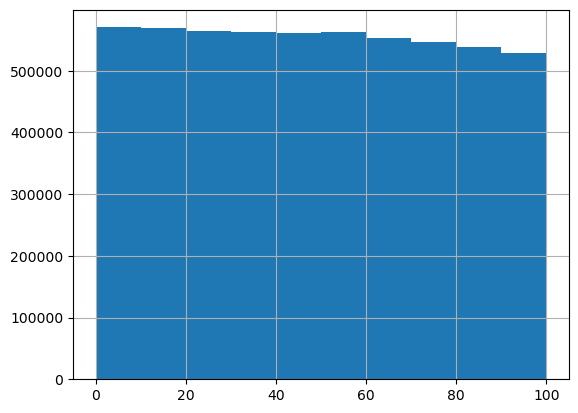

In [9]:
rascal_scores.mass_diff.hist()

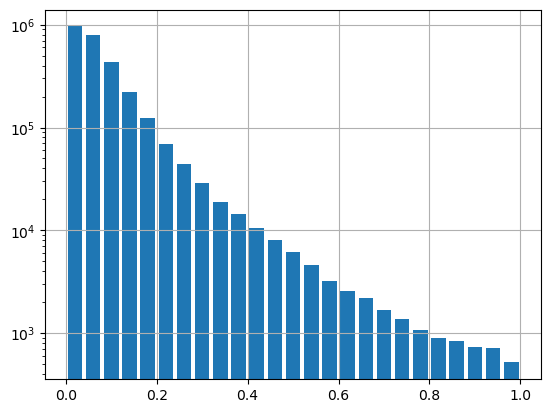

In [10]:
mask = (rascal_scores.timeout == False) & (rascal_scores.mass_diff <=50)

fig, ax = plt.subplots()
ax = rascal_scores[mask].rascal.hist(bins=25, rwidth=0.8)
ax.set_yscale("log")

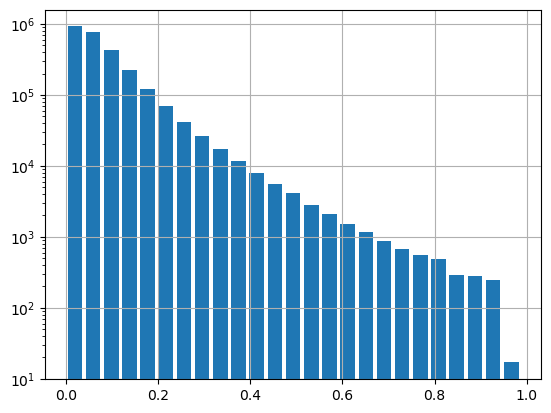

In [11]:
mask = (rascal_scores.timeout == False) & (rascal_scores.mass_diff > 50)

fig, ax = plt.subplots()
ax = rascal_scores[mask].rascal.hist(bins=25, rwidth=0.8)
ax.set_yscale("log")

In [12]:
rascal_scores.loc[~rascal_scores['timeout']].shape

(5413677, 7)

In [13]:
rascal_scores.loc[~rascal_scores['timeout']].dropna().shape

(5413677, 7)

# Compare MCES to fingerprint based scores

In [14]:
compounds_mapper = compounds.copy()
compounds_mapper["index"] = compounds_mapper.index
compounds_mapper = compounds_mapper.set_index("inchikey")
compounds_mapper = compounds_mapper.iloc[:, -1]
compounds_mapper

inchikey
AAAQFGUYHFJNHI        0
AABFWJDLCCDJJN        1
AABILZKQMVKFHP        2
AABUHSBGEIUSRJ        3
AABUKWVVUWBZCS        4
                  ...  
ZZYXNRREDYWPLN    37806
ZZZJZEXRSVMPPV    37807
ZZZQXCUPAJFVBN    37808
ZZZRUAITSXLWBH    37809
ZZZYHIMVKOHVIH    37810
Name: index, Length: 37811, dtype: int64

## Run experiments

In [36]:
experiments = [
    ("rdkit", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("rdkit_sparse", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("morgan3", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("morgan9", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), False),
    ("morgan12", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), False),
    ("morgan3_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("morgan9_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), False),
    ("morgan12_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), False),
    ("morgan3_count", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    ("morgan9_count", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_count", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("morgan3_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    ("morgan9_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("morgan3_logcount", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    ("morgan9_logcount", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_logcount", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("morgan3_logcount_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    ("morgan9_logcount_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_logcount_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("map2", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
    ("map2_sparse", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4_sparse", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
    ("mbp2", MBP(dimensions=4096, radius=1), False),
    ("mbp2_binned", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), False),
    ("mbp2_count", MBP(dimensions=4096, radius=1), True),
    ("mbp2_binned_count", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), True),
    ("mbp2_sparse", MBP(dimensions=4096, radius=1), False),
    ("mbp2_binned_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), False),
    ("mbp2_count_sparse", MBP(dimensions=4096, radius=1), True),
    ("mbp2_binned_count_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), True),
    ("mbp2_logcount_sparse", MBP(dimensions=4096, radius=1), True),
    ("mbp2_binned_logcount_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), True),
]

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1 import make_axes_locatable


def heatmap_comparison_flat(similarities1, similarities2, label1, label2, bins=50,
                       colormap="viridis",
                       add_region_percentage=True, filename=None,
                      ):
    """
    Generates a heatmap comparison of two similarity matrices.
    
    Parameters:
    similarities1 (ndarray): First similarity array.
    similarities2 (ndarray): Second similarity array.
    label1 (str): Label for the x-axis.
    label2 (str): Label for the y-axis.
    bins (int, optional): Number of bins for the 2D histogram (default: 50).
    colormap (str, optional): Colormap used for visualization (default: "viridis").
    filename (str, optional): If provided, saves the heatmap to the specified file.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Select upper triangle indices to ignore diagonal if necessary
    n = similarities1.shape[0]
    
    # Compute the 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        similarities1, 
        similarities2, 
        bins=bins
    )
    
    # Plot the heatmap using imshow with a logarithmic color scale
    im = ax.imshow(
        hist.T, origin='lower', aspect='equal',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        cmap=colormap, norm=LogNorm(vmin=1, vmax=np.max(hist))
    )
    
    # Create an axis of the same height for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("Count")
    
    # Compute total count for percentage calculations
    total_count = len(similarities1)
    
    # Add text annotations for each 5x5 section of bins
    step = bins // 5
    for i in range(0, bins, step):
        for j in range(0, bins, step):
            sub_matrix = hist[i:i+step, j:j+step]
            subsection_sum = np.sum(sub_matrix)
            
            if subsection_sum > 0 and add_region_percentage:
                # Compute the center of the bin for text placement
                x_center = (x_edges[i] + x_edges[min(i + step, bins - 1)]) / 2
                y_center = (y_edges[j] + y_edges[min(j + step, bins - 1)]) / 2
                
                # Add text annotation
                ax.text(
                    x_center, y_center, f"{(100 * subsection_sum / total_count):.2f}%",
                    color="white", ha="center", va="center", fontsize=6, zorder=2
                )
    
    # Configure grid, labels, and layout
    ax.grid(True, zorder=1)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    plt.tight_layout()
    
    # Save plot if a filename is provided
    if filename:
        plt.savefig(filename)
    
    # Show the plot
    plt.show()

In [18]:
path_results = os.path.join(Path(ROOT), "experiments", "rascal_correlation")

In [19]:
from metrics import jaccard_index, jaccard_index_sparse, ruzicka_similarity, ruzicka_similarity_sparse_numba

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau

def compare_scores(
    result_df: pd.DataFrame,
    fingerprints,
    metric_function,
    label1: str,
    label2: str,
    filename: str,
    plot_heatmap: bool = True,
    scaling: str = None,
    rascal_min: float = None
) -> dict:
    """
    Compare fingerprint-based similarities against rascalMCES
    using Pearson, Spearman, Kendall, and Concordance Correlation;
    optionally only on pairs with rascal >= rascal_min.

    Parameters
    ----------
    result_df : pd.DataFrame
        Must contain columns 'inchikey1','inchikey2','rascal','timeout'.
    fingerprints : Sequence
        Each element either a single‐FP array or a tuple (raw_fp, val_fp).
    metric_function : callable
        If single‐FP: metric(fp_i, fp_j).
        If tuple‐FP: metric(raw_i,val_i,raw_j,val_j).
    label1, label2 : str
        Labels for the axes in the heatmap.
    filename : str
        Where to save heatmap (pass None to skip saving).
    scaling : {None, 'log'}
        If 'log', applies np.log1p to fingerprint inputs.
    rascal_min : float, optional
        If set, only keep pairs with rascal >= rascal_min.

    Returns
    -------
    dict
        {
          'pearson': r,
          'spearman': rho,
          'kendall' : tau,
          'ccc'     : concordance_ccc
        }
    """
    # 1) filter timeouts + NaNs
    df = result_df.loc[~result_df['timeout']].copy().fillna(0.0)
    
    # 2) optionally filter by rascal threshold
    if rascal_min is not None:
        before = len(df)
        df = df.loc[df['rascal'] >= rascal_min]
        after = len(df)
        print(f"– Filtering to rascal ≥ {rascal_min}: {before} → {after} pairs")

    # 3) pull out rascal vector
    rascal = df['rascal'].values

    # 4) map inchikey → index via compounds_mapper
    idx1 = compounds_mapper.loc[df['inchikey1']].values
    idx2 = compounds_mapper.loc[df['inchikey2']].values

    # 5) compute fingerprint similarities
    fpsims = []
    for i, j in zip(idx1, idx2):
        fi, fj = fingerprints[i], fingerprints[j]

        if scaling == 'log':
            # apply log‐scaling to the 'value' part or to the whole fp
            if isinstance(fi, tuple):
                raw_i, val_i = fi
                raw_j, val_j = fj
                val_i, val_j = np.log1p(val_i), np.log1p(val_j)
                sim = metric_function(raw_i, val_i, raw_j, val_j)
            else:
                sim = metric_function(np.log1p(fi), np.log1p(fj))
        else:
            if isinstance(fi, tuple):
                sim = metric_function(fi[0], fi[1], fj[0], fj[1])
            else:
                sim = metric_function(fi, fj)

        fpsims.append(sim)
    fpsims = np.array(fpsims)

    # 6) compute correlations
    r,  p_r  = pearsonr(rascal, fpsims)
    rho, p_s = spearmanr(rascal, fpsims)
    tau, p_k = kendalltau(rascal, fpsims)

    # Lin’s CCC
    mean_r, mean_f = rascal.mean(), fpsims.mean()
    var_r, var_f   = rascal.var(ddof=1), fpsims.var(ddof=1)
    cov_rf         = np.cov(rascal, fpsims, ddof=1)[0,1]
    ccc = 2 * cov_rf / (var_r + var_f + (mean_r - mean_f)**2)

    # 7) report
    print(f"Pearson   r = {r:.4f} (p={p_r:.2e})")
    print(f"Spearman  ρ = {rho:.4f} (p={p_s:.2e})")
    print(f"Kendall   τ = {tau:.4f} (p={p_k:.2e})")
    print(f"Concordance CCC = {ccc:.4f}")

    if plot_heatmap:
        # 8) heatmap / scatter
        heatmap_comparison_flat(
            rascal, fpsims,
            f"{label1}" + (f" (≥{rascal_min})" if rascal_min is not None else ""),
            label2,
            filename=filename
        )

    return {
        'pearson':  r,
        'spearman': rho,
        'kendall':  tau,
        'ccc':      ccc
    }


In [23]:
filename = os.path.join(path_results, "results_rascal_correlations_250512.csv")

results_df = pd.read_csv(filename)
results = list(results_df.T.to_dict().values())

In [25]:
#results

----- Found existing results for experiment: rdkit -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: rdkit_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan3 -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan9 -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan12 -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan3_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan9_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan12_sparse -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan3_count -----
----- (experiment will be skipped) -----

----- Found existing results for experiment: morgan9_count 

Calculating sparse fingerprints:   0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
Pearson   r = 0.5900 (p=0.00e+00)
Spearman  ρ = 0.4907 (p=0.00e+00)
Kendall   τ = 0.3446 (p=0.00e+00)
Concordance CCC = 0.3646


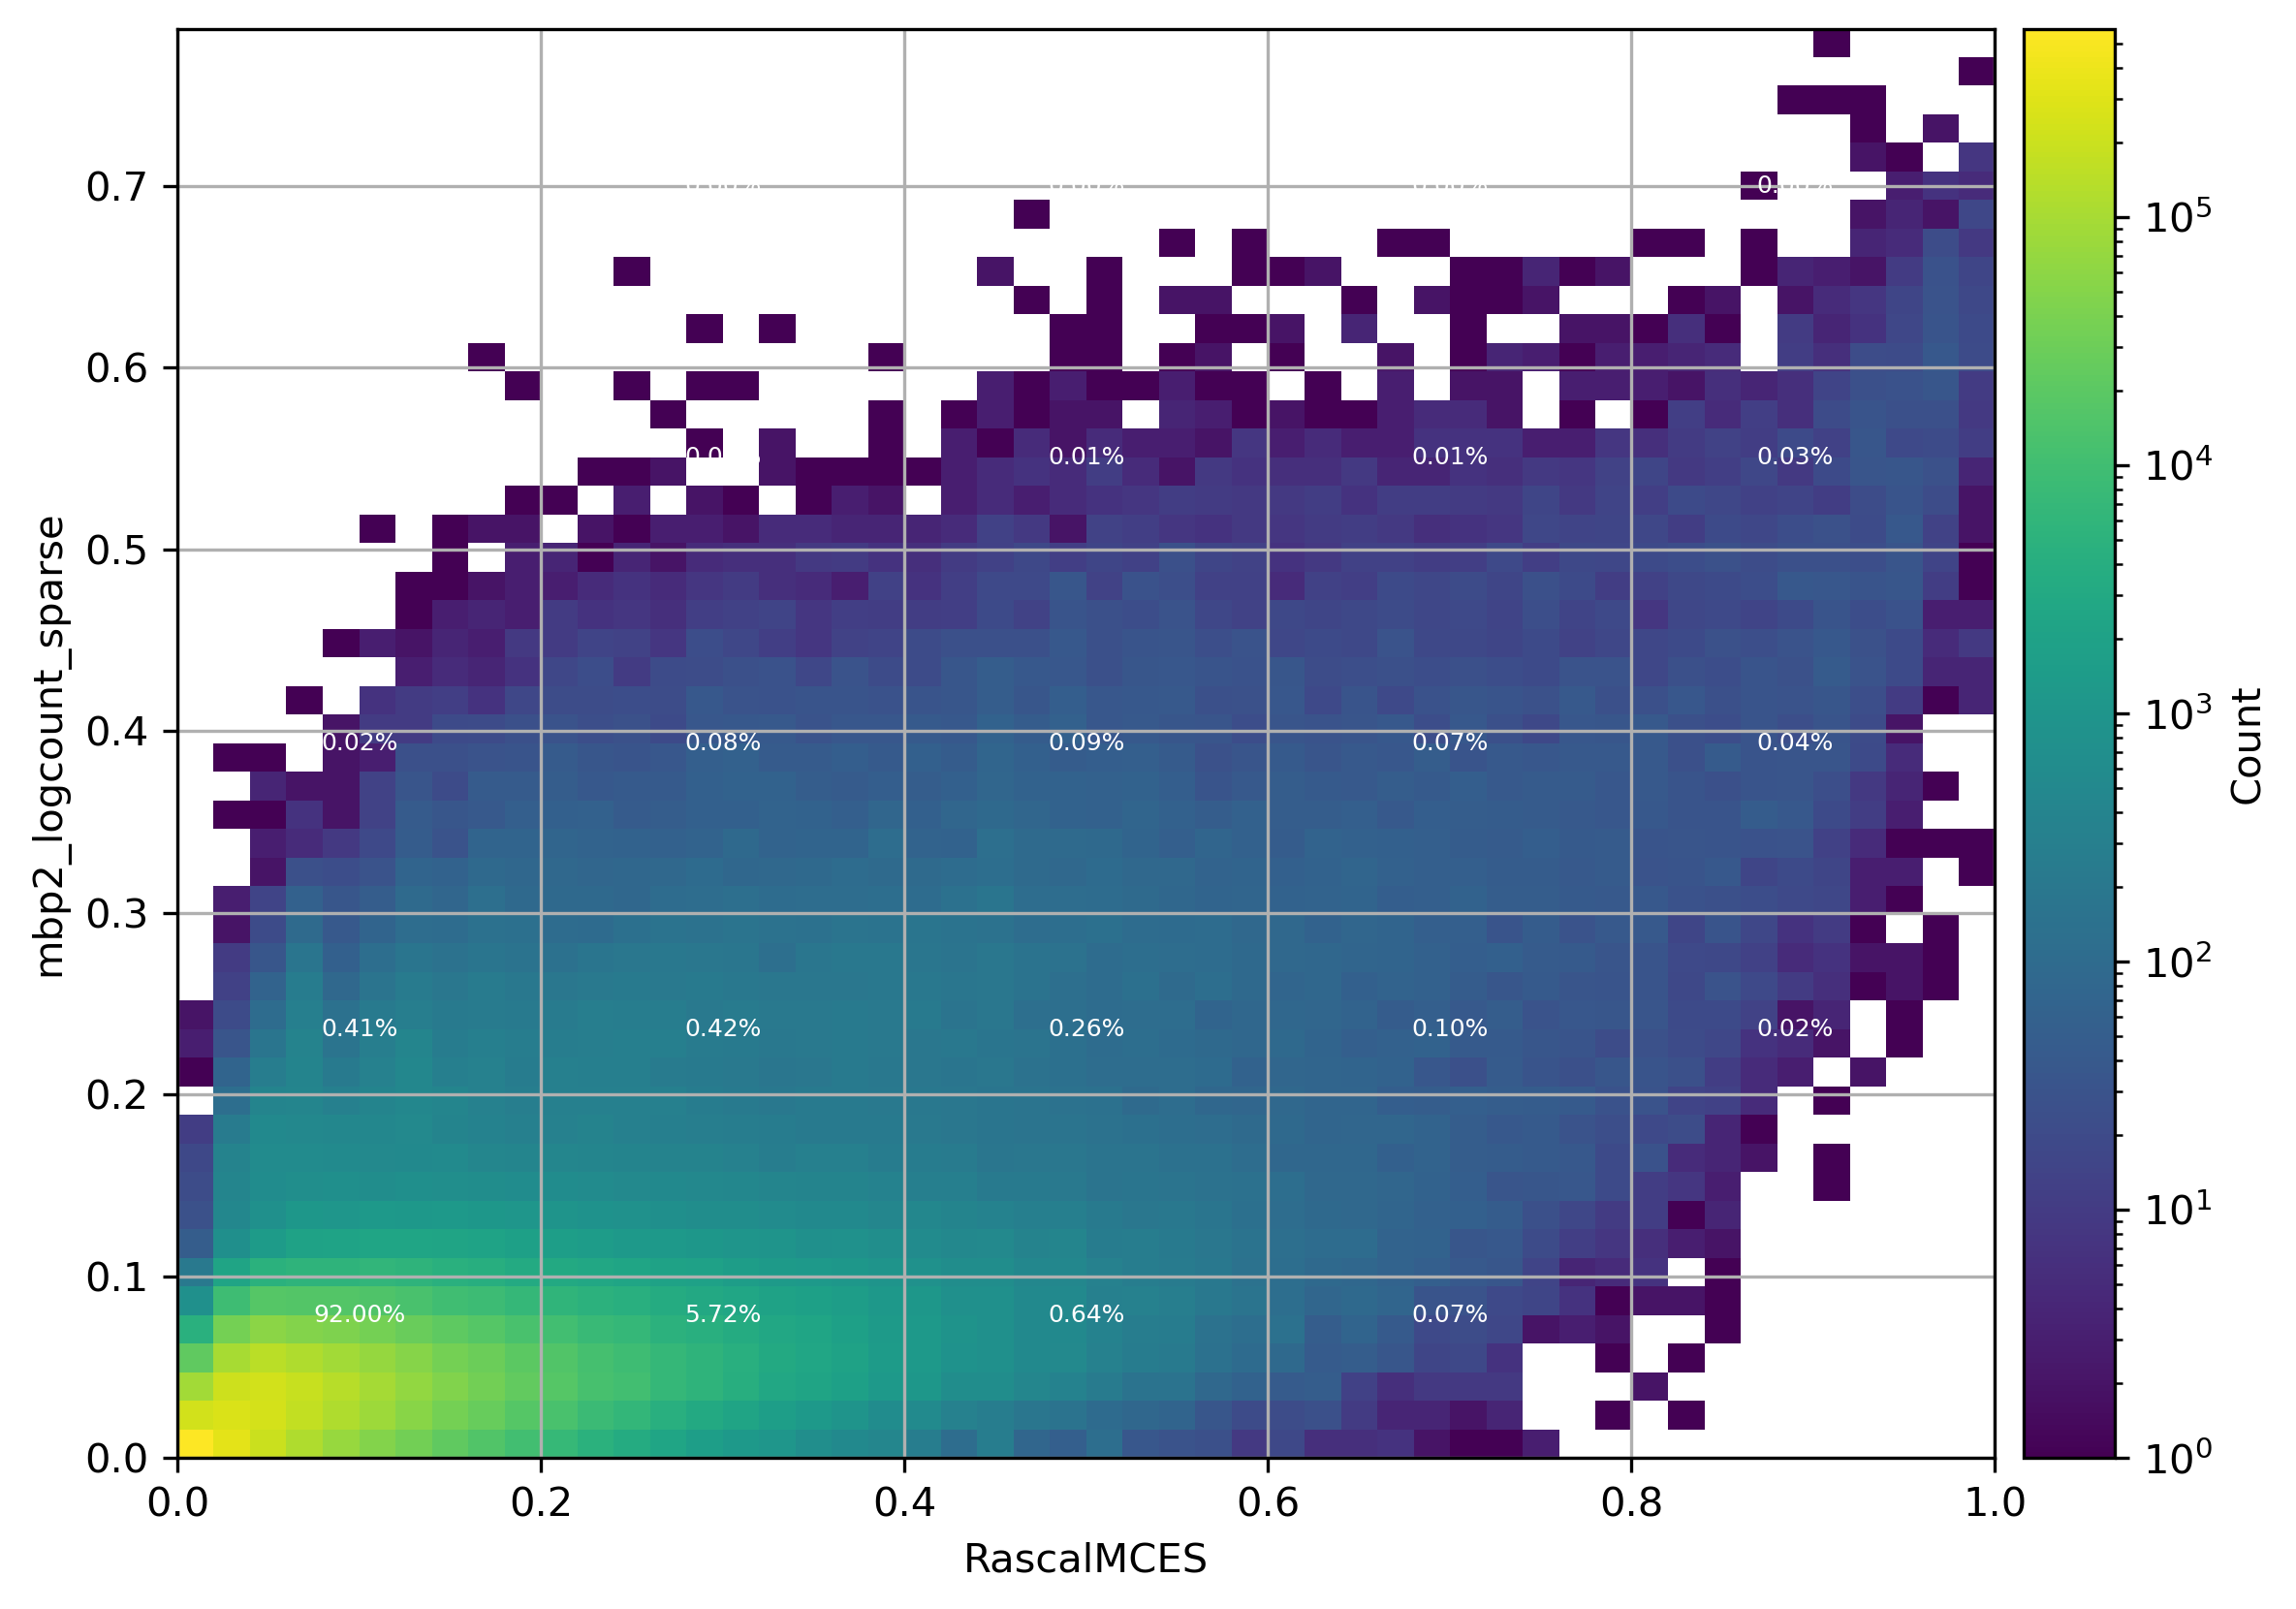

Results for mbp2_logcount_sparse:
  Pearson r = 0.59002
  Spearman ρ = 0.49067
  Kendall τ = 0.34457
  Concordance CCC = 0.36457

----- Experiment: mbp2_binned_logcount_sparse -----


Calculating sparse fingerprints:   0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
Pearson   r = 0.5906 (p=0.00e+00)
Spearman  ρ = 0.5045 (p=0.00e+00)
Kendall   τ = 0.3557 (p=0.00e+00)
Concordance CCC = 0.3799


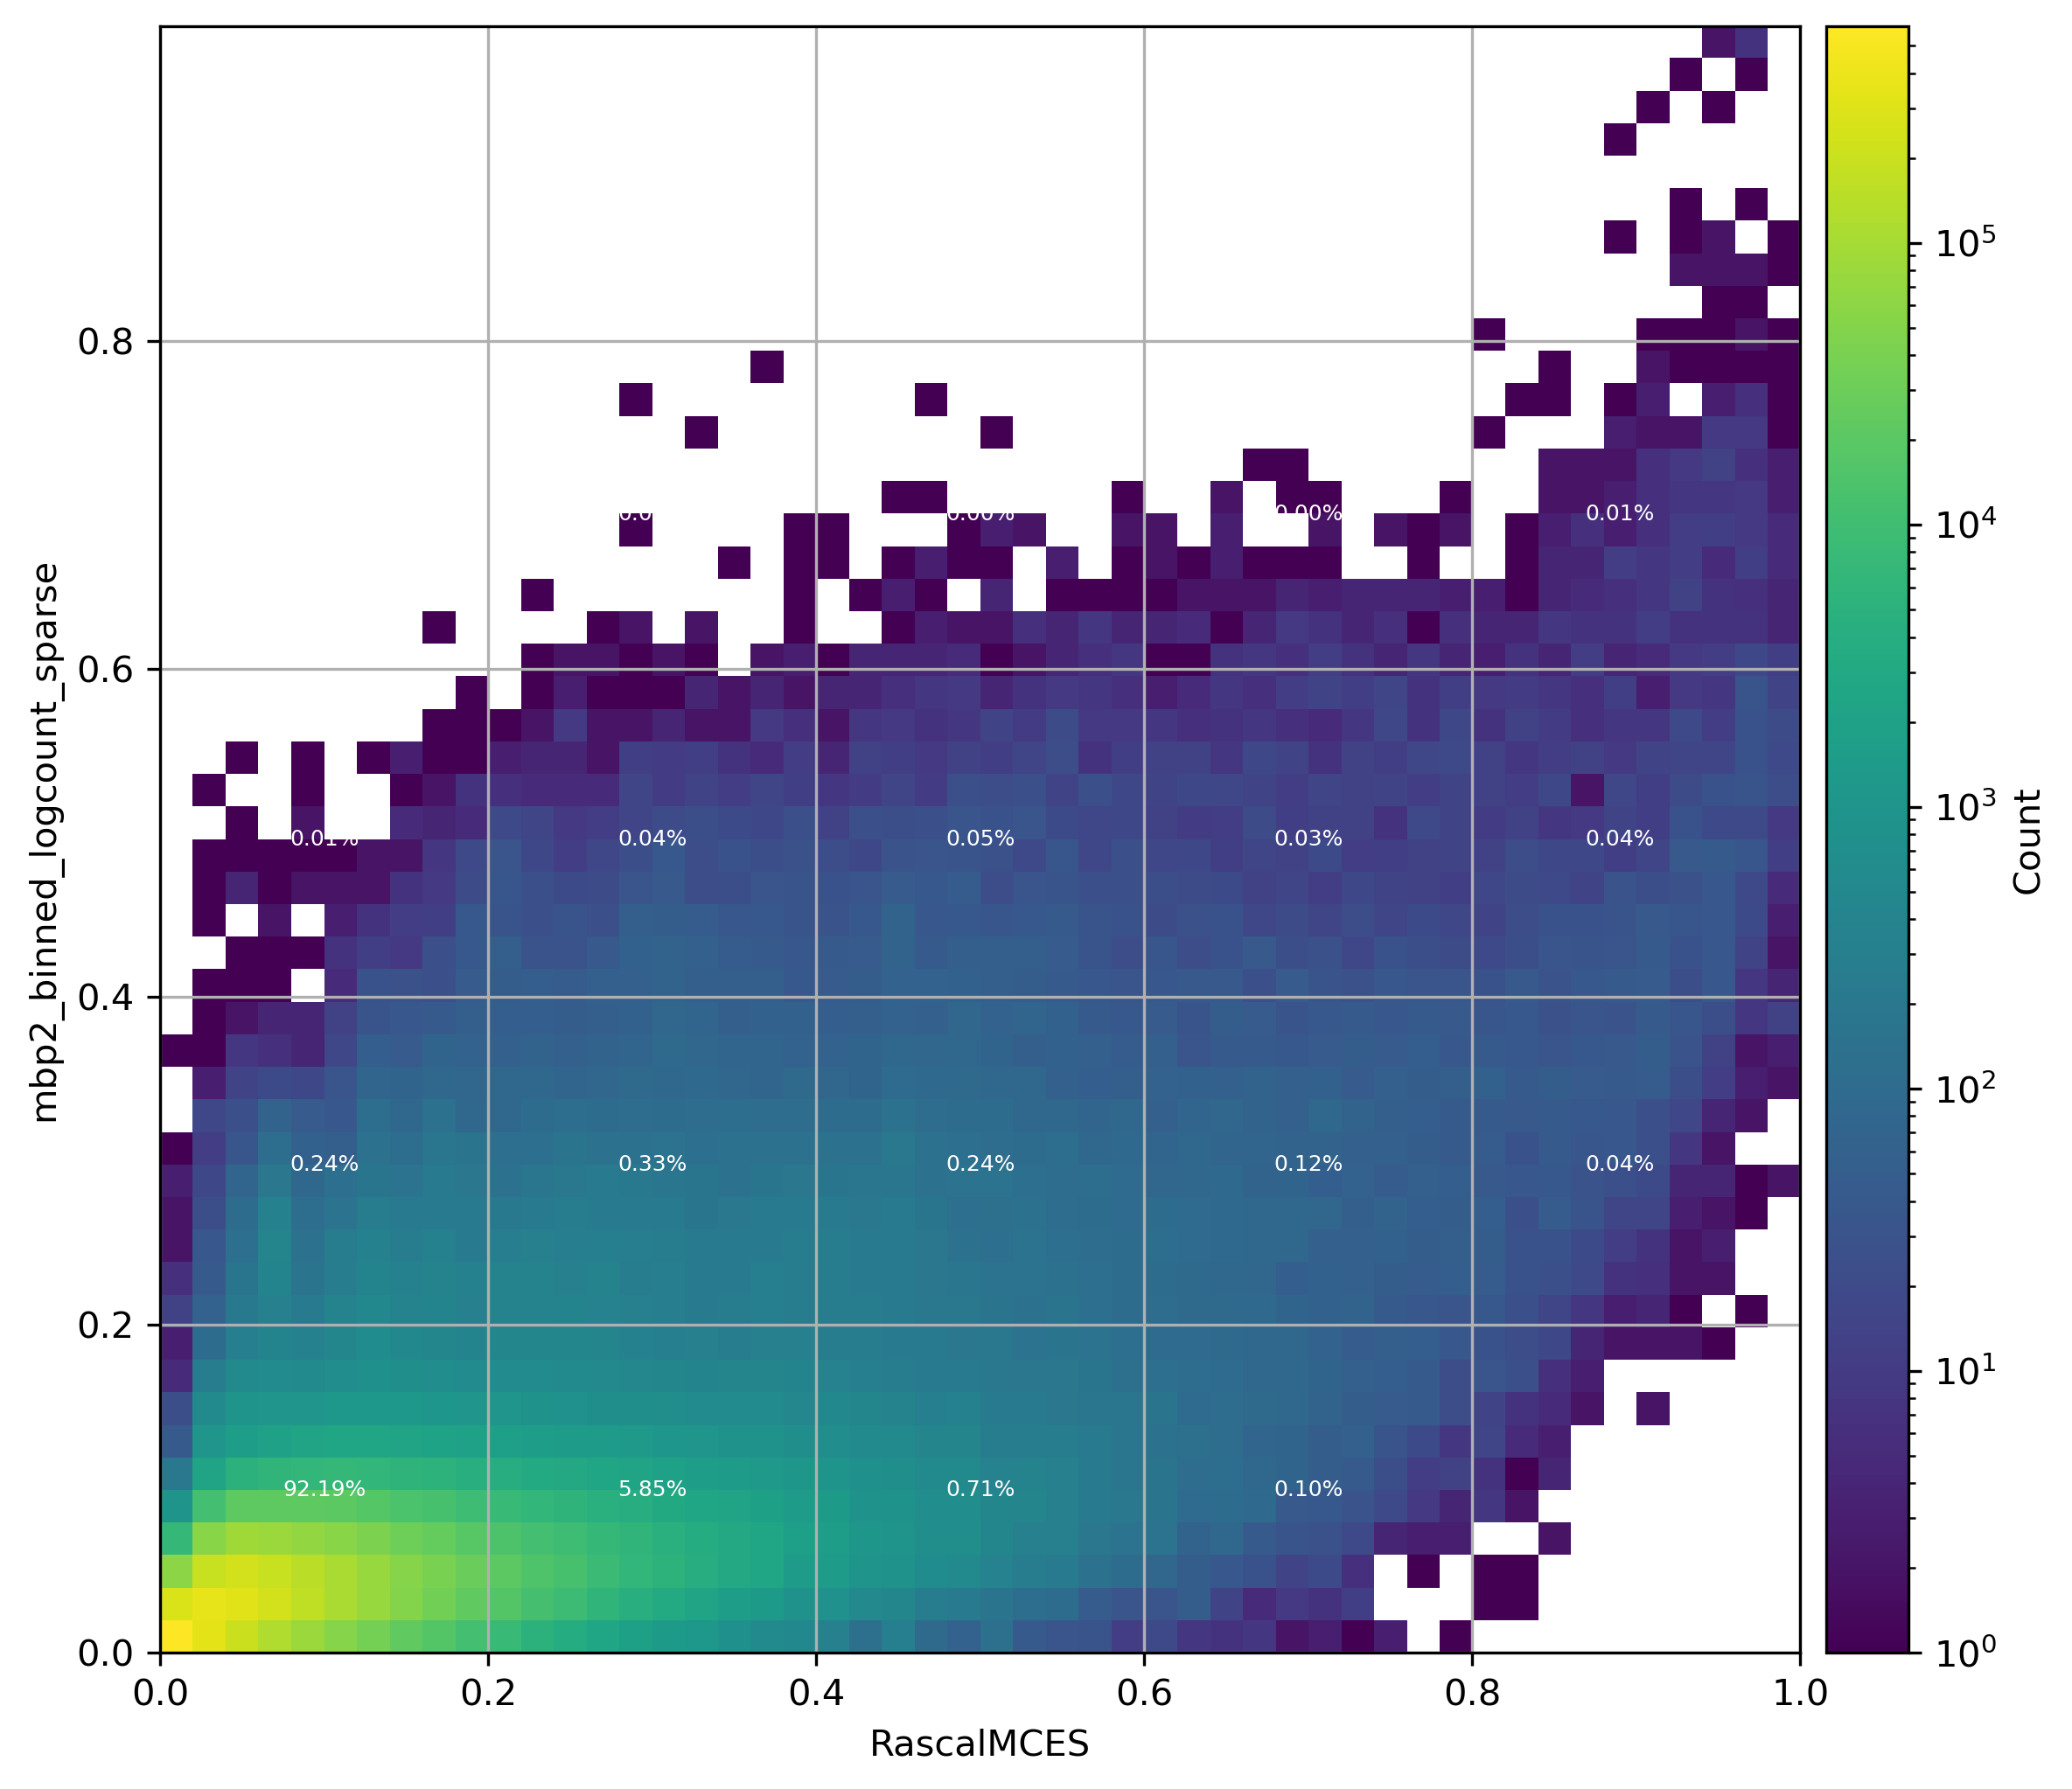

Results for mbp2_binned_logcount_sparse:
  Pearson r = 0.59064
  Spearman ρ = 0.50455
  Kendall τ = 0.35574
  Concordance CCC = 0.37992

Wrote summary to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/rascal_correlation/results_rascal_correlations_250515.csv


In [37]:
#results = []

for experiment in experiments:
    name, fpgen, count = experiment

    # where we'll save the heatmap
    plot_filename = os.path.join(path_results, f"{name}_rascal_comparison.png")

    if os.path.exists(plot_filename):
        print(f"----- Found existing results for experiment: {name} -----")
        print("----- (experiment will be skipped) -----\n")
        continue

    print(f"----- Experiment: {name} -----")

    # determine if we need log‐scaling
    scaling = "log" if "logcount" in name else None

    # 1) compute / load fingerprints
    if "_sparse" in name:
        if "map" in name:
            fingerprints = compute_sparse_map_fingerprints_from_smiles_serial(
                compounds.smiles, fpgen, count=count
            )
        elif "mbp" in name:
            fingerprints = compute_sparse_map_fingerprints_from_smiles(
                compounds.smiles, fpgen, count=count
            )
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen,
                sparse=True, count=count, progress_bar=True
            )
        print(f"Collected {len(fingerprints)} sparse fingerprints.")
    else:
        if ("map" in name) or ("mbp" in name):
            fingerprints = compute_map_fingerprints_from_smiles(
                compounds.smiles, fpgen
            )
            fingerprints = np.stack(fingerprints)
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen,
                sparse=False, count=count, progress_bar=True
            )
            fingerprints = np.stack(fingerprints)
        print(f"Collected {fingerprints.shape[0]} dense fingerprints.")

    # 2) pick the right similarity metric
    if "_sparse" in name:
        metric = ruzicka_similarity_sparse_numba if "count" in name else jaccard_index_sparse
    else:
        metric = ruzicka_similarity if "count" in name else jaccard_index

    # 3) run the comparison
    metrics = compare_scores(
        rascal_scores,
        fingerprints,
        metric,
        label1="RascalMCES",
        label2=name,
        filename=plot_filename,
        scaling=scaling
    )

    # 4) report to console
    print(f"Results for {name}:")
    print(f"  Pearson r = {metrics['pearson']:.5f}")
    print(f"  Spearman ρ = {metrics['spearman']:.5f}")
    print(f"  Kendall τ = {metrics['kendall']:.5f}")
    print(f"  Concordance CCC = {metrics['ccc']:.5f}\n")

    # 5) record for CSV
    record = {"experiment": name}
    record.update(metrics)
    results.append(record)

# after all experiments, dump to CSV
results_df = pd.DataFrame(results)
filename = os.path.join(path_results, "results_rascal_correlations_250515.csv")
results_df.to_csv(filename, index=False)
print(f"Wrote summary to {filename}")

In [33]:
filename = os.path.join(path_results, "results_rascal_correlations_250515.csv")

results_df = pd.read_csv(filename)
results_df = results_df.set_index("experiment")
results_df.sort_values("kendall", ascending=False)

,pearson,spearman,kendall,ccc
experiment,,,,
rdkit_sparse,0.641534,0.643092,0.470765,0.614070
morgan12_logcount_sparse,0.682281,0.609998,0.438663,0.488352
morgan9_logcount_sparse,0.679329,0.607671,0.436914,0.509262
map4_sparse,0.563984,0.595072,0.433341,0.281649
map2_sparse,0.593747,0.585599,0.426127,0.416015
morgan12_sparse,0.677314,0.582979,0.417075,0.408883
morgan12_count_sparse,0.641747,0.585872,0.416928,0.542825
morgan9_sparse,0.670894,0.579886,0.414752,0.432713
morgan9_count_sparse,0.640953,0.582937,0.414699,0.556943


In [116]:
#results_df = pd.read_csv(filename)
#list(results_df.T.to_dict().values())

In [34]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_tau_comparison(tau_series, title="", filename=None):
    """
    Create a comparison plot of Kendall's tau for dense vs. sparse variants,
    with a legend for the two marker types.
    
    Parameters
    ----------
    tau_series : pd.Series
        Index are experiment names, values are Kendall tau.
    filename : str or None
        If provided, save figure to this path.
        
    Returns
    -------
    fig : matplotlib.figure.Figure
    """
    # 1) Group into dense vs. sparse by base name
    groups = {}
    for name, tau in tau_series.items():
        if name.endswith('_sparse'):
            base = name[:-7]
            groups.setdefault(base, {})['sparse'] = tau
        else:
            groups.setdefault(name, {})['dense'] = tau

    # 2) Determine sort order by max tau in each group, ascending
    sorted_bases = sorted(
        groups.keys(),
        key=lambda base: max(groups[base].values()),
        reverse=False
    )
    
    # 3) Plot
    fig, ax = plt.subplots(figsize=(8, len(sorted_bases) * 0.4))
    y_positions = list(range(len(sorted_bases)))
    for y, base in zip(y_positions, sorted_bases):
        vals = groups[base]
        if 'dense' in vals and 'sparse' in vals:
            ax.plot([vals['dense'], vals['sparse']], [y, y], ":", color="black", linewidth=2)
        if 'dense' in vals:
            ax.plot(vals['dense'], y, marker='o', color="crimson")
        if 'sparse' in vals:
            ax.plot(vals['sparse'], y, marker='s', color="teal")

    all_taus = [tau
            for vals in groups.values()
            for tau in vals.values()]
    # only draw zero‐line if any tau ≤ 0
    if min(all_taus) <= 0:
        ax.axvline(0, linestyle='--', linewidth=1.5, color='black')

    # 5) Labels and ticks
    ax.set_yticks(y_positions)
    names_cleaned = [x.replace("_", " ").replace("logcount", "log count") for x in sorted_bases]
    ax.set_yticklabels(names_cleaned)
    ax.set_xlabel("Kendall's $τ_B$")
    ax.set_title(title)
    ax.grid(True)

    # 6) Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='crimson', linestyle='None', label='4096 bit vector'),
        Line2D([0], [0], marker='s', color='teal',   linestyle='None', label='Sparse')
    ]
    ax.legend(handles=legend_elements, loc='lower left')

    plt.tight_layout()

    # 7) Save or show
    if filename:
        fig.savefig(filename, dpi=450)
    plt.show()

    return fig


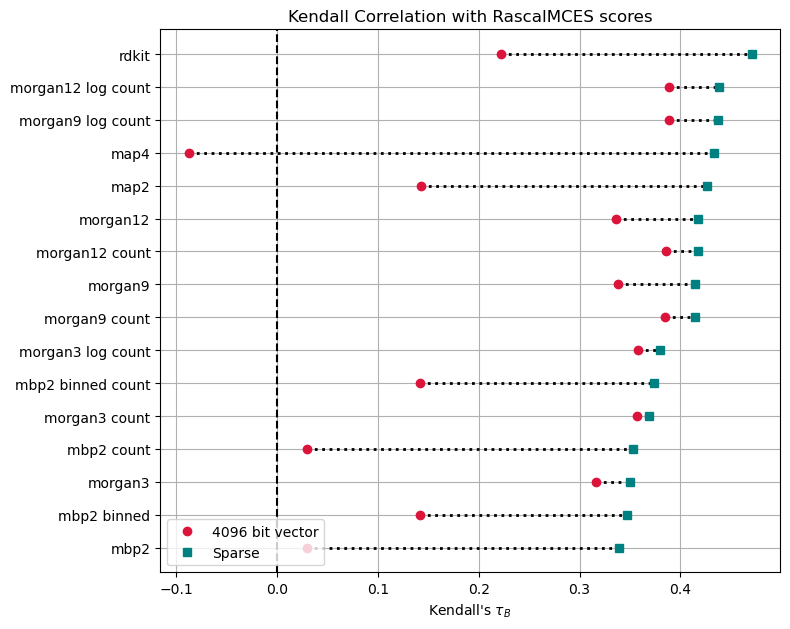

In [35]:
plot_tau_comparison(
    results_df.kendall,
    "Kendall Correlation with RascalMCES scores",
    #"rascal_kendall_correlation_full.png"
)
plt.show()

# Run again with only Rascal Scores >= 0.2

In [49]:
results = []

for experiment in experiments:
    name, fpgen, count = experiment

    # where we'll save the heatmap
    plot_filename = os.path.join(path_results, f"{name}_rascal_comparison.png")

    """
    if os.path.exists(plot_filename):
        print(f"----- Found existing results for experiment: {name} -----")
        print("----- (experiment will be skipped) -----\n")
        continue
    """
    print(f"----- Experiment: {name} -----")

    # determine if we need log‐scaling
    scaling = "log" if "logcount" in name else None

    # 1) compute / load fingerprints
    if "_sparse" in name:
        if "map" in name:
            fingerprints = compute_sparse_map_fingerprints_from_smiles_serial(
                compounds.smiles, fpgen, count=count
            )
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen,
                sparse=True, count=count, progress_bar=True
            )
        print(f"Collected {len(fingerprints)} sparse fingerprints.")
    else:
        if "map" in name:
            fingerprints = compute_map_fingerprints_from_smiles(
                compounds.smiles, fpgen
            )
            fingerprints = np.stack(fingerprints)
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen,
                sparse=False, count=count, progress_bar=True
            )
            fingerprints = np.stack(fingerprints)
        print(f"Collected {fingerprints.shape[0]} dense fingerprints.")

    # 2) pick the right similarity metric
    if "_sparse" in name:
        metric = ruzicka_similarity_sparse_numba if "count" in name else jaccard_index_sparse
    else:
        metric = ruzicka_similarity if "count" in name else jaccard_index

    # 3) run the comparison
    metrics = compare_scores(
        rascal_scores,
        fingerprints,
        metric,
        rascal_min=0.2,
        plot_heatmap=False,
        label1="RascalMCES",
        label2=name,
        filename=plot_filename,
        scaling=scaling
    )

    # 4) report to console
    print(f"Results for {name}:")
    print(f"  Pearson r = {metrics['pearson']:.5f}")
    print(f"  Spearman ρ = {metrics['spearman']:.5f}")
    print(f"  Kendall τ = {metrics['kendall']:.5f}")
    print(f"  Concordance CCC = {metrics['ccc']:.5f}\n")

    # 5) record for CSV
    record = {"experiment": name}
    record.update(metrics)
    results.append(record)

# after all experiments, dump to CSV
results_df = pd.DataFrame(results)
filename = os.path.join(path_results, "results_rascal_lg_0_2_correlations_250512.csv")
results_df.to_csv(filename, index=False)
print(f"Wrote summary to {filename}")

----- Experiment: rdkit -----


100%|████████████████████████████████████| 37811/37811 [00:45<00:00, 829.70it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.5355 (p=0.00e+00)
Spearman  ρ = 0.3649 (p=0.00e+00)
Kendall   τ = 0.2478 (p=0.00e+00)
Concordance CCC = 0.4564
Results for rdkit:
  Pearson r = 0.53552
  Spearman ρ = 0.36490
  Kendall τ = 0.24778
  Concordance CCC = 0.45643

----- Experiment: rdkit_sparse -----


100%|████████████████████████████████████| 37811/37811 [00:45<00:00, 828.65it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.5807 (p=0.00e+00)
Spearman  ρ = 0.4824 (p=0.00e+00)
Kendall   τ = 0.3342 (p=0.00e+00)
Concordance CCC = 0.4333
Results for rdkit_sparse:
  Pearson r = 0.58067
  Spearman ρ = 0.48236
  Kendall τ = 0.33418
  Concordance CCC = 0.43327

----- Experiment: morgan3 -----


100%|███████████████████████████████████| 37811/37811 [00:06<00:00, 6287.27it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.5202 (p=0.00e+00)
Spearman  ρ = 0.3886 (p=0.00e+00)
Kendall   τ = 0.2656 (p=0.00e+00)
Concordance CCC = 0.3296
Results for morgan3:
  Pearson r = 0.52020
  Spearman ρ = 0.38865
  Kendall τ = 0.26558
  Concordance CCC = 0.32957

----- Experiment: morgan9 -----


100%|███████████████████████████████████| 37811/37811 [00:08<00:00, 4218.57it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.6215 (p=0.00e+00)
Spearman  ρ = 0.4320 (p=0.00e+00)
Kendall   τ = 0.2975 (p=0.00e+00)
Concordance CCC = 0.2314
Results for morgan9:
  Pearson r = 0.62155
  Spearman ρ = 0.43197
  Kendall τ = 0.29752
  Concordance CCC = 0.23142

----- Experiment: morgan12 -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 3917.37it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.6358 (p=0.00e+00)
Spearman  ρ = 0.4345 (p=0.00e+00)
Kendall   τ = 0.2998 (p=0.00e+00)
Concordance CCC = 0.2074
Results for morgan12:
  Pearson r = 0.63583
  Spearman ρ = 0.43452
  Kendall τ = 0.29978
  Concordance CCC = 0.20736

----- Experiment: morgan3_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:05<00:00, 6316.61it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.5222 (p=0.00e+00)
Spearman  ρ = 0.3976 (p=0.00e+00)
Kendall   τ = 0.2720 (p=0.00e+00)
Concordance CCC = 0.3237
Results for morgan3_sparse:
  Pearson r = 0.52224
  Spearman ρ = 0.39757
  Kendall τ = 0.27202
  Concordance CCC = 0.32373

----- Experiment: morgan9_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 4059.41it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.6300 (p=0.00e+00)
Spearman  ρ = 0.4452 (p=0.00e+00)
Kendall   τ = 0.3073 (p=0.00e+00)
Concordance CCC = 0.2191
Results for morgan9_sparse:
  Pearson r = 0.62998
  Spearman ρ = 0.44518
  Kendall τ = 0.30727
  Concordance CCC = 0.21911

----- Experiment: morgan12_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 3823.14it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.6442 (p=0.00e+00)
Spearman  ρ = 0.4477 (p=0.00e+00)
Kendall   τ = 0.3096 (p=0.00e+00)
Concordance CCC = 0.1933
Results for morgan12_sparse:
  Pearson r = 0.64416
  Spearman ρ = 0.44773
  Kendall τ = 0.30962
  Concordance CCC = 0.19331

----- Experiment: morgan3_count -----


100%|███████████████████████████████████| 37811/37811 [00:06<00:00, 5905.55it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.5506 (p=0.00e+00)
Spearman  ρ = 0.3905 (p=0.00e+00)
Kendall   τ = 0.2674 (p=0.00e+00)
Concordance CCC = 0.4091
Results for morgan3_count:
  Pearson r = 0.55063
  Spearman ρ = 0.39047
  Kendall τ = 0.26744
  Concordance CCC = 0.40913

----- Experiment: morgan9_count -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 3912.75it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.6264 (p=0.00e+00)
Spearman  ρ = 0.4339 (p=0.00e+00)
Kendall   τ = 0.2993 (p=0.00e+00)
Concordance CCC = 0.3174
Results for morgan9_count:
  Pearson r = 0.62638
  Spearman ρ = 0.43389
  Kendall τ = 0.29933
  Concordance CCC = 0.31745

----- Experiment: morgan12_count -----


100%|███████████████████████████████████| 37811/37811 [00:10<00:00, 3659.06it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.6396 (p=0.00e+00)
Spearman  ρ = 0.4368 (p=0.00e+00)
Kendall   τ = 0.3019 (p=0.00e+00)
Concordance CCC = 0.2946
Results for morgan12_count:
  Pearson r = 0.63961
  Spearman ρ = 0.43676
  Kendall τ = 0.30188
  Concordance CCC = 0.29458

----- Experiment: morgan3_count_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:06<00:00, 6005.77it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.5522 (p=0.00e+00)
Spearman  ρ = 0.3963 (p=0.00e+00)
Kendall   τ = 0.2717 (p=0.00e+00)
Concordance CCC = 0.4045
Results for morgan3_count_sparse:
  Pearson r = 0.55219
  Spearman ρ = 0.39630
  Kendall τ = 0.27166
  Concordance CCC = 0.40452

----- Experiment: morgan9_count_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 3926.04it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.6339 (p=0.00e+00)
Spearman  ρ = 0.4435 (p=0.00e+00)
Kendall   τ = 0.3064 (p=0.00e+00)
Concordance CCC = 0.3072
Results for morgan9_count_sparse:
  Pearson r = 0.63387
  Spearman ρ = 0.44354
  Kendall τ = 0.30642
  Concordance CCC = 0.30722

----- Experiment: morgan12_count_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:10<00:00, 3651.28it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.6489 (p=0.00e+00)
Spearman  ρ = 0.4472 (p=0.00e+00)
Kendall   τ = 0.3096 (p=0.00e+00)
Concordance CCC = 0.2824
Results for morgan12_count_sparse:
  Pearson r = 0.64894
  Spearman ρ = 0.44716
  Kendall τ = 0.30961
  Concordance CCC = 0.28243

----- Experiment: morgan3_logcount_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:06<00:00, 5850.57it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.5461 (p=0.00e+00)
Spearman  ρ = 0.4072 (p=0.00e+00)
Kendall   τ = 0.2791 (p=0.00e+00)
Concordance CCC = 0.3686
Results for morgan3_logcount_sparse:
  Pearson r = 0.54606
  Spearman ρ = 0.40724
  Kendall τ = 0.27910
  Concordance CCC = 0.36861

----- Experiment: morgan9_logcount_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 3831.63it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.6439 (p=0.00e+00)
Spearman  ρ = 0.4570 (p=0.00e+00)
Kendall   τ = 0.3159 (p=0.00e+00)
Concordance CCC = 0.2581
Results for morgan9_logcount_sparse:
  Pearson r = 0.64387
  Spearman ρ = 0.45698
  Kendall τ = 0.31595
  Concordance CCC = 0.25813

----- Experiment: morgan12_logcount_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:10<00:00, 3586.19it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.6583 (p=0.00e+00)
Spearman  ρ = 0.4605 (p=0.00e+00)
Kendall   τ = 0.3191 (p=0.00e+00)
Concordance CCC = 0.2310
Results for morgan12_logcount_sparse:
  Pearson r = 0.65827
  Spearman ρ = 0.46048
  Kendall τ = 0.31906
  Concordance CCC = 0.23100

----- Experiment: map2 -----


Calculating fingerprints:   0%|                       | 0/37811 [00:00<?, ?it/s]

Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.5443 (p=0.00e+00)
Spearman  ρ = 0.4075 (p=0.00e+00)
Kendall   τ = 0.2794 (p=0.00e+00)
Concordance CCC = 0.2795
Results for map2:
  Pearson r = 0.54426
  Spearman ρ = 0.40749
  Kendall τ = 0.27938
  Concordance CCC = 0.27951

----- Experiment: map4 -----


Calculating fingerprints:   0%|                       | 0/37811 [00:00<?, ?it/s]

Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.4977 (p=0.00e+00)
Spearman  ρ = 0.2918 (p=0.00e+00)
Kendall   τ = 0.1960 (p=0.00e+00)
Concordance CCC = 0.2355
Results for map4:
  Pearson r = 0.49775
  Spearman ρ = 0.29183
  Kendall τ = 0.19600
  Concordance CCC = 0.23548

----- Experiment: map2_sparse -----


  0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.5584 (p=0.00e+00)
Spearman  ρ = 0.4504 (p=0.00e+00)
Kendall   τ = 0.3119 (p=0.00e+00)
Concordance CCC = 0.2538
Results for map2_sparse:
  Pearson r = 0.55840
  Spearman ρ = 0.45038
  Kendall τ = 0.31192
  Concordance CCC = 0.25381

----- Experiment: map4_sparse -----


  0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.2: 5413677 → 409654 pairs
Pearson   r = 0.5541 (p=0.00e+00)
Spearman  ρ = 0.4446 (p=0.00e+00)
Kendall   τ = 0.3074 (p=0.00e+00)
Concordance CCC = 0.1786
Results for map4_sparse:
  Pearson r = 0.55409
  Spearman ρ = 0.44461
  Kendall τ = 0.30737
  Concordance CCC = 0.17858

Wrote summary to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/rascal_correlation/results_rascal_lg_0_2_correlations_250512.csv


In [125]:
filename = os.path.join(path_results, "results_rascal_lg_0_2_correlations_250512.csv")

results_df = pd.read_csv(filename)
results_df = results_df.set_index("experiment")
results_df.sort_values("kendall", ascending=False)

,pearson,spearman,kendall,ccc
experiment,,,,
rdkit_sparse,0.580672,0.482361,0.334182,0.433273
morgan12_logcount_sparse,0.658267,0.460481,0.319062,0.231003
morgan9_logcount_sparse,0.643872,0.456975,0.315947,0.258129
map2_sparse,0.558397,0.450381,0.311925,0.253813
morgan12_sparse,0.644165,0.447731,0.309622,0.193314
morgan12_count_sparse,0.648938,0.447159,0.309615,0.282426
map4_sparse,0.554092,0.444608,0.307365,0.178581
morgan9_sparse,0.629981,0.445182,0.307268,0.219106
morgan9_count_sparse,0.633866,0.443539,0.306423,0.307225


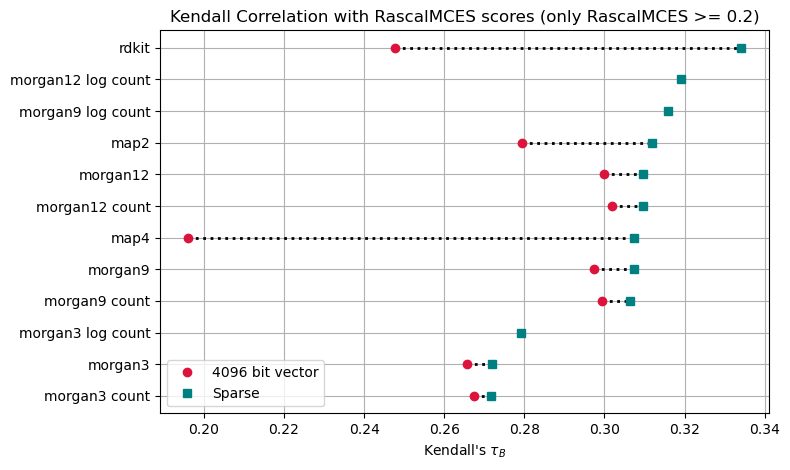

In [132]:
plot_tau_comparison(
    results_df.kendall,
    "Kendall Correlation with RascalMCES scores (only RascalMCES >= 0.2)",
    "rascal_kendall_correlation_lg_0_2.png"
)
plt.show()

# Run again with only Rascal Scores >= 0.5

In [45]:
results = []

for experiment in experiments:
    name, fpgen, count = experiment

    # where we'll save the heatmap
    plot_filename = os.path.join(path_results, f"{name}_rascal_comparison.png")

    """
    if os.path.exists(plot_filename):
        print(f"----- Found existing results for experiment: {name} -----")
        print("----- (experiment will be skipped) -----\n")
        continue
    """
    print(f"----- Experiment: {name} -----")

    # determine if we need log‐scaling
    scaling = "log" if "logcount" in name else None

    # 1) compute / load fingerprints
    if "_sparse" in name:
        if "map" in name:
            fingerprints = compute_sparse_map_fingerprints_from_smiles_serial(
                compounds.smiles, fpgen, count=count
            )
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen,
                sparse=True, count=count, progress_bar=True
            )
        print(f"Collected {len(fingerprints)} sparse fingerprints.")
    else:
        if "map" in name:
            fingerprints = compute_map_fingerprints_from_smiles(
                compounds.smiles, fpgen
            )
            fingerprints = np.stack(fingerprints)
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen,
                sparse=False, count=count, progress_bar=True
            )
            fingerprints = np.stack(fingerprints)
        print(f"Collected {fingerprints.shape[0]} dense fingerprints.")

    # 2) pick the right similarity metric
    if "_sparse" in name:
        metric = ruzicka_similarity_sparse_numba if "count" in name else jaccard_index_sparse
    else:
        metric = ruzicka_similarity if "count" in name else jaccard_index

    # 3) run the comparison
    metrics = compare_scores(
        rascal_scores,
        fingerprints,
        metric,
        rascal_min=0.5,
        plot_heatmap=False,
        label1="RascalMCES",
        label2=name,
        filename=plot_filename,
        scaling=scaling
    )

    # 4) report to console
    print(f"Results for {name}:")
    print(f"  Pearson r = {metrics['pearson']:.5f}")
    print(f"  Spearman ρ = {metrics['spearman']:.5f}")
    print(f"  Kendall τ = {metrics['kendall']:.5f}")
    print(f"  Concordance CCC = {metrics['ccc']:.5f}\n")

    # 5) record for CSV
    record = {"experiment": name}
    record.update(metrics)
    results.append(record)

# after all experiments, dump to CSV
results_df = pd.DataFrame(results)
filename = os.path.join(path_results, "results_rascal_lg_0_5_correlations_250512.csv")
results_df.to_csv(filename, index=False)
print(f"Wrote summary to {filename}")

----- Experiment: rdkit -----


100%|████████████████████████████████████| 37811/37811 [00:41<00:00, 906.73it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4819 (p=0.00e+00)
Spearman  ρ = 0.4505 (p=0.00e+00)
Kendall   τ = 0.3168 (p=0.00e+00)
Concordance CCC = 0.3411
Results for rdkit:
  Pearson r = 0.48194
  Spearman ρ = 0.45045
  Kendall τ = 0.31676
  Concordance CCC = 0.34109

----- Experiment: rdkit_sparse -----


100%|████████████████████████████████████| 37811/37811 [00:44<00:00, 853.26it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4858 (p=0.00e+00)
Spearman  ρ = 0.4571 (p=0.00e+00)
Kendall   τ = 0.3228 (p=0.00e+00)
Concordance CCC = 0.3248
Results for rdkit_sparse:
  Pearson r = 0.48584
  Spearman ρ = 0.45705
  Kendall τ = 0.32284
  Concordance CCC = 0.32483

----- Experiment: morgan3 -----


100%|███████████████████████████████████| 37811/37811 [00:05<00:00, 6413.53it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4336 (p=0.00e+00)
Spearman  ρ = 0.3966 (p=0.00e+00)
Kendall   τ = 0.2748 (p=0.00e+00)
Concordance CCC = 0.1811
Results for morgan3:
  Pearson r = 0.43361
  Spearman ρ = 0.39658
  Kendall τ = 0.27484
  Concordance CCC = 0.18115

----- Experiment: morgan9 -----


100%|███████████████████████████████████| 37811/37811 [00:08<00:00, 4229.40it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.5184 (p=0.00e+00)
Spearman  ρ = 0.4302 (p=0.00e+00)
Kendall   τ = 0.2965 (p=0.00e+00)
Concordance CCC = 0.1216
Results for morgan9:
  Pearson r = 0.51838
  Spearman ρ = 0.43017
  Kendall τ = 0.29654
  Concordance CCC = 0.12161

----- Experiment: morgan12 -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 3941.73it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.5511 (p=0.00e+00)
Spearman  ρ = 0.4476 (p=0.00e+00)
Kendall   τ = 0.3087 (p=0.00e+00)
Concordance CCC = 0.1083
Results for morgan12:
  Pearson r = 0.55109
  Spearman ρ = 0.44763
  Kendall τ = 0.30869
  Concordance CCC = 0.10833

----- Experiment: morgan3_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:05<00:00, 6396.67it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4321 (p=0.00e+00)
Spearman  ρ = 0.3961 (p=0.00e+00)
Kendall   τ = 0.2745 (p=0.00e+00)
Concordance CCC = 0.1781
Results for morgan3_sparse:
  Pearson r = 0.43206
  Spearman ρ = 0.39609
  Kendall τ = 0.27450
  Concordance CCC = 0.17811

----- Experiment: morgan9_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 4125.14it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.5212 (p=0.00e+00)
Spearman  ρ = 0.4313 (p=0.00e+00)
Kendall   τ = 0.2972 (p=0.00e+00)
Concordance CCC = 0.1168
Results for morgan9_sparse:
  Pearson r = 0.52120
  Spearman ρ = 0.43126
  Kendall τ = 0.29717
  Concordance CCC = 0.11684

----- Experiment: morgan12_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 3881.58it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.5551 (p=0.00e+00)
Spearman  ρ = 0.4498 (p=0.00e+00)
Kendall   τ = 0.3101 (p=0.00e+00)
Concordance CCC = 0.1030
Results for morgan12_sparse:
  Pearson r = 0.55511
  Spearman ρ = 0.44983
  Kendall τ = 0.31010
  Concordance CCC = 0.10304

----- Experiment: morgan3_count -----


100%|███████████████████████████████████| 37811/37811 [00:06<00:00, 5959.87it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4980 (p=0.00e+00)
Spearman  ρ = 0.4394 (p=0.00e+00)
Kendall   τ = 0.3062 (p=0.00e+00)
Concordance CCC = 0.2439
Results for morgan3_count:
  Pearson r = 0.49796
  Spearman ρ = 0.43942
  Kendall τ = 0.30619
  Concordance CCC = 0.24387

----- Experiment: morgan9_count -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 3968.12it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.5669 (p=0.00e+00)
Spearman  ρ = 0.4719 (p=0.00e+00)
Kendall   τ = 0.3281 (p=0.00e+00)
Concordance CCC = 0.1683
Results for morgan9_count:
  Pearson r = 0.56687
  Spearman ρ = 0.47193
  Kendall τ = 0.32807
  Concordance CCC = 0.16828

----- Experiment: morgan12_count -----


100%|███████████████████████████████████| 37811/37811 [00:10<00:00, 3676.75it/s]


Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.5991 (p=0.00e+00)
Spearman  ρ = 0.4942 (p=0.00e+00)
Kendall   τ = 0.3440 (p=0.00e+00)
Concordance CCC = 0.1533
Results for morgan12_count:
  Pearson r = 0.59910
  Spearman ρ = 0.49422
  Kendall τ = 0.34396
  Concordance CCC = 0.15327

----- Experiment: morgan3_count_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:06<00:00, 5977.58it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4968 (p=0.00e+00)
Spearman  ρ = 0.4390 (p=0.00e+00)
Kendall   τ = 0.3059 (p=0.00e+00)
Concordance CCC = 0.2413
Results for morgan3_count_sparse:
  Pearson r = 0.49685
  Spearman ρ = 0.43899
  Kendall τ = 0.30591
  Concordance CCC = 0.24131

----- Experiment: morgan9_count_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 3902.42it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.5686 (p=0.00e+00)
Spearman  ρ = 0.4731 (p=0.00e+00)
Kendall   τ = 0.3288 (p=0.00e+00)
Concordance CCC = 0.1642
Results for morgan9_count_sparse:
  Pearson r = 0.56863
  Spearman ρ = 0.47306
  Kendall τ = 0.32881
  Concordance CCC = 0.16425

----- Experiment: morgan12_count_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:10<00:00, 3663.10it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.6031 (p=0.00e+00)
Spearman  ρ = 0.4975 (p=0.00e+00)
Kendall   τ = 0.3463 (p=0.00e+00)
Concordance CCC = 0.1487
Results for morgan12_count_sparse:
  Pearson r = 0.60311
  Spearman ρ = 0.49754
  Kendall τ = 0.34628
  Concordance CCC = 0.14871

----- Experiment: morgan3_logcount_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:06<00:00, 5886.81it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4705 (p=0.00e+00)
Spearman  ρ = 0.4194 (p=0.00e+00)
Kendall   τ = 0.2911 (p=0.00e+00)
Concordance CCC = 0.2099
Results for morgan3_logcount_sparse:
  Pearson r = 0.47054
  Spearman ρ = 0.41937
  Kendall τ = 0.29110
  Concordance CCC = 0.20990

----- Experiment: morgan9_logcount_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:09<00:00, 3882.30it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.5524 (p=0.00e+00)
Spearman  ρ = 0.4593 (p=0.00e+00)
Kendall   τ = 0.3179 (p=0.00e+00)
Concordance CCC = 0.1367
Results for morgan9_logcount_sparse:
  Pearson r = 0.55244
  Spearman ρ = 0.45931
  Kendall τ = 0.31793
  Concordance CCC = 0.13674

----- Experiment: morgan12_logcount_sparse -----


100%|███████████████████████████████████| 37811/37811 [00:10<00:00, 3592.66it/s]


Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.5864 (p=0.00e+00)
Spearman  ρ = 0.4823 (p=0.00e+00)
Kendall   τ = 0.3342 (p=0.00e+00)
Concordance CCC = 0.1213
Results for morgan12_logcount_sparse:
  Pearson r = 0.58643
  Spearman ρ = 0.48231
  Kendall τ = 0.33419
  Concordance CCC = 0.12125

----- Experiment: map2 -----


Calculating fingerprints:   0%|                       | 0/37811 [00:00<?, ?it/s]

Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4780 (p=0.00e+00)
Spearman  ρ = 0.4332 (p=0.00e+00)
Kendall   τ = 0.3043 (p=0.00e+00)
Concordance CCC = 0.1636
Results for map2:
  Pearson r = 0.47802
  Spearman ρ = 0.43318
  Kendall τ = 0.30427
  Concordance CCC = 0.16361

----- Experiment: map4 -----


Calculating fingerprints:   0%|                       | 0/37811 [00:00<?, ?it/s]

Collected 37811 dense fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4774 (p=0.00e+00)
Spearman  ρ = 0.4219 (p=0.00e+00)
Kendall   τ = 0.2942 (p=0.00e+00)
Concordance CCC = 0.1438
Results for map4:
  Pearson r = 0.47739
  Spearman ρ = 0.42192
  Kendall τ = 0.29423
  Concordance CCC = 0.14378

----- Experiment: map2_sparse -----


  0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4679 (p=0.00e+00)
Spearman  ρ = 0.4195 (p=0.00e+00)
Kendall   τ = 0.2956 (p=0.00e+00)
Concordance CCC = 0.1452
Results for map2_sparse:
  Pearson r = 0.46792
  Spearman ρ = 0.41952
  Kendall τ = 0.29559
  Concordance CCC = 0.14517

----- Experiment: map4_sparse -----


  0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
– Filtering to rascal ≥ 0.5: 5413677 → 35286 pairs
Pearson   r = 0.4761 (p=0.00e+00)
Spearman  ρ = 0.4169 (p=0.00e+00)
Kendall   τ = 0.2922 (p=0.00e+00)
Concordance CCC = 0.1061
Results for map4_sparse:
  Pearson r = 0.47608
  Spearman ρ = 0.41686
  Kendall τ = 0.29222
  Concordance CCC = 0.10607

Wrote summary to /home/daisy/Florian/molecular_fingerprint_comparisons/experiments/rascal_correlation/results_rascal_lg_0_5_correlations_250512.csv


In [48]:
results_df.sort_values("kendall", ascending=False)

,experiment,pearson,spearman,kendall,ccc
13,morgan12_count_sparse,0.603108,0.497541,0.346285,0.148713
10,morgan12_count,0.599100,0.494215,0.343964,0.153269
16,morgan12_logcount_sparse,0.586428,0.482312,0.334188,0.121255
12,morgan9_count_sparse,0.568626,0.473064,0.328814,0.164245
9,morgan9_count,0.566873,0.471929,0.328073,0.168282
1,rdkit_sparse,0.485844,0.457055,0.322836,0.324831
15,morgan9_logcount_sparse,0.552440,0.459313,0.317925,0.136740
0,rdkit,0.481936,0.450451,0.316761,0.341088
7,morgan12_sparse,0.555109,0.449829,0.310104,0.103041
4,morgan12,0.551089,0.447632,0.308690,0.108334
